# Simple Q-Learning Example

How do I teach a robot to escape a burning building? 
Implementing this example: http://mnemstudio.org/path-finding-q-learning-tutorial.htm

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import sys
import matplotlib
libraries = (('Matplotlib', matplotlib), ('Numpy', np))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1


Let's start by taking a look at the house we're trying to escape.

<img src="http://mnemstudio.org/ai/path/images/modeling_environment_clip_image002a.gif">

So, state 5 is where we need to end up. To do that, we want to create a reward matrix. Which tells us when we've taken a good or a bad action.

> -1 = impossible action

> 0 = possible action that doesn't directly lead outside

> 100 = made it outside

Let's set some basic inputs for the whole system.

In [9]:
reward = np.array([[-1, -1, -1, -1, 0, -1],
                   [-1, -1, -1, 0, -1, 100],
                   [-1, -1, -1, 0, -1, -1],
                   [-1, 0, 0, -1, 0, -1],
                   [0, -1, -1, 0, -1, 100],
                   [-1, 0, -1, -1, 0, 100]])
q_matrix = np.zeros((6,6)) # This functions as the brain for our robot - what it learns is in these rewards
future_rewards = 0.5
reward

array([[ -1,  -1,  -1,  -1,   0,  -1],
       [ -1,  -1,  -1,   0,  -1, 100],
       [ -1,  -1,  -1,   0,  -1,  -1],
       [ -1,   0,   0,  -1,   0,  -1],
       [  0,  -1,  -1,   0,  -1, 100],
       [ -1,   0,  -1,  -1,   0, 100]])

In [10]:
def update_robot_brain(q_matrix, future_rewards, current_state, next_state):
    """
    Updates the learned matrix, Q with a simple rule:
    Q[i,j] = Reward[i,j] + future_reward_weight*max(Q[i])
    
    Basically, what is my reward plus what do I already know this 
    step can lead to in terms of reward.
    """
    q_matrix[current_state, next_state] = reward[current_state, next_state] + future_rewards*np.max(q_matrix[next_state])
    return q_matrix

In [11]:
def learning_episode(q_matrix, reward, future_rewards=0.5, starting_state=2, verbose=False):
    """
    Start from some random room and move around randomly, figuring out what the reward
    for each random step is. Do this until you end up outside of the building. Update
    Q along the way to make sure you're learning.
    """
    state = starting_state
    while state != 5:
        possible_moves = reward[state] >= 0 # this is a true false list of legal moves
        legal_moves = np.where(possible_moves)[0] # now we take only legal moves (the [0] selects the legals)
        if verbose:
            print(legal_moves)
        new_state = np.random.choice(legal_moves)
        q_matrix = update_robot_brain(q_matrix, future_rewards, state, new_state)
        state = new_state
    return q_matrix
        
learning_episode(q_matrix, reward, verbose=True)
print('---')
learning_episode(q_matrix, reward, verbose=True)

[3]
[1 2 4]
[3]
[1 2 4]
[3 5]
---
[3]
[1 2 4]
[3 5]
[1 2 4]
[0 3 5]
[1 2 4]
[0 3 5]
[1 2 4]
[3]
[1 2 4]
[3 5]
[1 2 4]
[3]
[1 2 4]
[3 5]


array([[   0. ,    0. ,    0. ,    0. ,    0. ,    0. ],
       [   0. ,    0. ,    0. ,   25. ,    0. ,  100. ],
       [   0. ,    0. ,    0. ,   25. ,    0. ,    0. ],
       [   0. ,   50. ,   12.5,    0. ,   12.5,    0. ],
       [   0. ,    0. ,    0. ,   25. ,    0. ,    0. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ]])

Okay, so we have it learning the reward structure for it's actions. Note that right now, there are so many zeros that it's only updating the spots where the next step is a 100. After those start to fill in, the future_rewards will start to fill in smaller values that aren't just "WE MADE IT TO THE END." Now let's let it REALLY learn by setting it to complete tons of episodes, where we randomly initalize where it starts.

In [12]:
for episode in range(int(1e4)):
    start_state = np.random.randint(6)
    q_matrix = learning_episode(q_matrix, reward)
    
q_matrix

array([[   0. ,    0. ,    0. ,    0. ,   50. ,    0. ],
       [   0. ,    0. ,    0. ,   25. ,    0. ,  100. ],
       [   0. ,    0. ,    0. ,   25. ,    0. ,    0. ],
       [   0. ,   50. ,   12.5,    0. ,   50. ,    0. ],
       [  25. ,    0. ,    0. ,   25. ,    0. ,  100. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ]])

In [13]:
def take_step(q_matrix, state):
    """
    Figure out which step results in the biggest reward
    """
    return np.argmax(q_matrix[state])

def escape_building(q_matrix, state):
    """
    While still in the building, take the rewardiest step from the room 
    you're in until you escape the building.
    """
    while state != 5:
        print(state)
        state = take_step(q_matrix, state)
    print(state)

escape_building(q_matrix, 2)

2
3
1
5


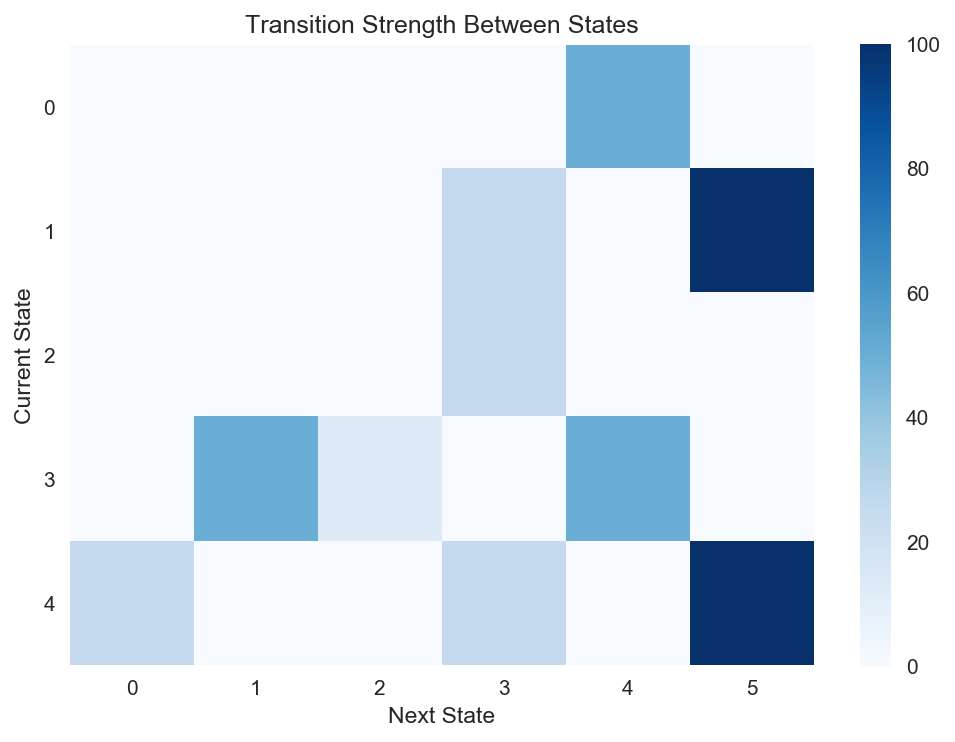

In [15]:
plt.figure(dpi=150)
plt.imshow(q_matrix[:5], cmap=plt.cm.Blues);
plt.colorbar();
plt.ylabel("Current State")
plt.xlabel("Next State")
plt.title("Transition Strength Between States");
plt.grid(False)

Now let's make it a bit more complicated. Let's imagine that we have the same floor plan again as a 2nd story. But this time, there are no doors to the outside, but there is a staircase that connects room 0 to the one directly above it. So let's look at the diagram again and build a new rewards matrix.

<img src="http://mnemstudio.org/ai/path/images/modeling_environment_clip_image002a.gif">

So we'll say room 0 is connected to room 6 by a staircase. Then room 7 is over room 1, room 8 over room 2, room 9 over room 3, room 10 over room 4. All doors are the same, except rooms 7 and 10 can't go outside since they're on the second floor. Let's also say there's a 20 point reward for going down the stairs.

In [16]:
reward = np.array([[-1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1],
                   [-1, -1, -1, 0, -1, 100, -1, -1, -1, -1, -1],
                   [-1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1],
                   [-1, 0, 0, -1, 0, -1, -1, -1, -1, -1, -1],
                   [0, -1, -1, 0, -1, 100, -1, -1, -1, -1, -1],
                   [-1, 0, -1, -1, 0, 100, -1, -1, -1, -1, -1],
                   [20, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1],
                   [-1, -1, -1, -1, -1, -1, -1, 0, 0, -1, 0],
                   [-1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1]])
reward.shape

(11, 11)

In [18]:
q_matrix = np.zeros_like(reward)
q_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [19]:
for episode in range(int(1e4)):
    start_state = np.random.randint(6)
    q_matrix = learning_episode(q_matrix, reward)
    
q_matrix

array([[  0,   0,   0,   0,  50,   0,  22,   0,   0,   0,   0],
       [  0,   0,   0,  25,   0, 100,   0,   0,   0,   0,   0],
       [  0,   0,   0,  25,   0,   0,   0,   0,   0,   0,   0],
       [  0,  50,  12,   0,  50,   0,   0,   0,   0,   0,   0],
       [ 25,   0,   0,  25,   0, 100,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 45,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   2,   0,  11],
       [  0,   0,   0,   0,   0,   0,  22,   0,   0,   5,   0]])

Let's update our building escape to make a note of when we go downstairs!

In [24]:
def escape_building(q_matrix, state):
    """
    While still in the building, take the rewardiest step from the room 
    you're in until you escape the building.
    """
    while state != 5:
        print(state)
        old_state = state
        state = take_step(q_matrix, state)
        if old_state == 6 and state == 0:
            print("---DOWNSTAIRS---")
    print(state)

In [25]:
escape_building(q_matrix, 8)

8
9
10
6
---DOWNSTAIRS---
0
4
5


In [26]:
escape_building(q_matrix, 7)

7
9
10
6
---DOWNSTAIRS---
0
4
5


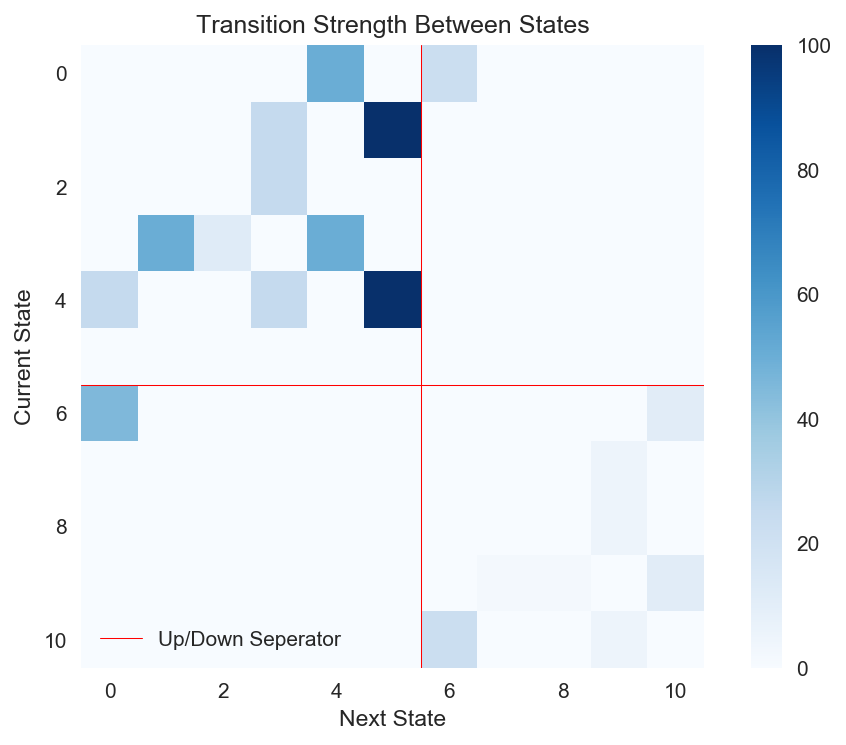

In [33]:
plt.figure(dpi=150)
plt.imshow(q_matrix, cmap=plt.cm.Blues);
plt.colorbar();
plt.ylabel("Current State")
plt.xlabel("Next State")
plt.title("Transition Strength Between States");
plt.grid(False)
plt.plot([-0.5,10.5],[5.5,5.5],'r', lw=0.5, label="Up/Down Seperator")
plt.plot([5.5,5.5],[-0.5,10.5],'r', lw=0.5);
plt.legend(loc="lower left");